# Feature evaluation
This notebook explores the engeineered features.

## Load dependencies

In [23]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from definitions import GEN_PATH, ROOT_DIR

sns.set_context('notebook')
sns.set_style('white')

## Load processed data

In [2]:
# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

## Extract training and validation data
Test data should not be used, even in, feature evaluation.

In [3]:
# Split data set into train and test
# Start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Testing will be done on 2019 matches
data_train = data.loc[data.tourney_date < test_date_begin]
data_train = pd.get_dummies(data_train, columns=['home_advantage'])

renames = {
    'home_advantage_-1': 'p2_home',
    'home_advantage_0': 'none_home',
    'home_advantage_1': 'p1_home',
}

data_train.rename(columns=renames, inplace=True)

## OPTIONAL: Removing low level matches
Testing to remove low level matches to see if different
is present for tour level matches. This means train and evaluate 
on only tour matches

In [11]:
tourneys = [2,3,5,6]
data_mask = (data_train.tourney_level.isin(tourneys))
data_train = data_train.loc[data_mask]

## Split data set into validation and training part

In [45]:
drop_cols = ['outcome', 'tourney_date']
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

X_train.tourney_level[X_train.tourney_level == 4] = 3
X_train.tourney_level[X_train.tourney_level == 5] = 4
X_train.tourney_level[X_train.tourney_level == 6] = 4

scale_cols = ['tourney_level', 'player_1', 'player_2']
X_train[scale_cols] = StandardScaler().fit_transform(X_train[scale_cols])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

display(X_train)

/Users/Jon/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Jon/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Jon/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,tourney_level,player_1,player_2,p2_home,none_home,p1_home
73682,-0.218557,-1.056294,-0.165825,-0.484995,-0.579601,-0.075426,0.358590,0.288436,-0.029251,0.000408,1.610251,3.638087,-0.410582,0,1,0
28112,-0.715468,-0.458714,0.589934,0.576888,0.344619,0.012261,-0.666556,-0.425970,0.071721,0.684673,-0.801352,-0.299470,-0.410582,0,1,0
47021,0.499204,0.046931,-0.000751,-0.000729,0.000642,-0.069272,0.462865,0.240809,0.542927,1.505791,1.610251,-0.281027,-0.336728,0,1,0
32758,-0.605043,-0.228875,-0.000751,-0.000729,0.000642,-0.053889,0.190667,0.050301,0.374640,-1.231269,-0.801352,-0.116121,-0.342989,0,1,0
58731,0.278355,0.000964,-1.056824,-1.033439,-0.614346,0.098409,-2.500172,0.383690,0.542927,1.642644,0.404449,-0.163446,-0.283091,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49420,-0.163344,-2.067585,0.482537,0.250155,-0.048001,0.273783,-1.194702,-0.283089,-0.870691,0.000408,-0.801352,-0.362798,-0.372108,0,1,0
43240,0.443992,0.000964,-0.000751,-0.000729,0.000642,-0.007738,0.018680,0.621826,1.115106,0.000408,1.610251,-0.274587,1.149557,0,1,0
45344,-0.163344,-1.240165,-0.126048,-0.000729,-1.319672,0.038413,-0.976673,-0.283089,-0.567772,0.000408,-0.801352,-0.334793,-0.214518,0,1,0
3355,0.167930,-0.090972,2.642415,2.583962,1.539851,-0.056965,1.181957,0.240809,-0.264854,0.000408,-0.801352,-0.150273,-0.271776,0,1,0


## OPTIONAL: Remove correlated features

In [15]:
col_remove = ['rel_total_wins', 'mutual_wins', 'mutual_surface_wins', 'rel_climate_wins']
X_train.drop(col_remove, inplace=True, axis=1)
X_val.drop(col_remove, inplace=True, axis=1)

## Correlation heatmap

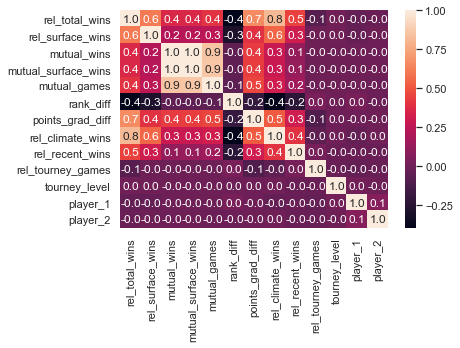

In [49]:
adv = ['p2_home', 'none_home', 'p1_home']
X_heat = X_train.drop(adv, axis=1)
sns.heatmap(X_heat.corr(), annot=True, fmt='.1f')
plt.show()

## Feature importance
Question being answered: which features help split our tree in the best way possible?
How does each feature affect the accuracy of our model?

1.0000000000000002


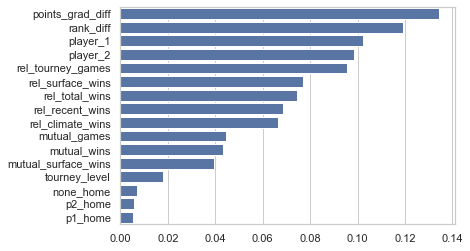

In [48]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

sns.set(style="whitegrid")
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
plt.show()

## Recursive feature elimination by feature importance
This takes a bit of time (large set...). 
Prune the results from previous sections. 
A ranking of 1 means the algorithm suggests the feature.
Remove highly correlated feature first

In [11]:
model = RandomForestClassifier()
rfe_model = RFE(model)  # selects 5 features
rfe_model.fit(X_train, y_train)

rfe_results = pd.DataFrame(rfe_model.ranking_, index=X_train.columns, columns=['ranking'])

display(rfe_results)
print('\nNumber of features selected: %d' % rfe_model.n_features_)

,ranking
rel_total_wins,2
rel_surface_wins,1
mutual_wins,4
mutual_surface_wins,5
mutual_games,3
rank_diff,1
points_grad_diff,1
rel_climate_wins,1
rel_recent_wins,1
rel_tourney_games,1



Number of features selected: 6


## Classification report

Full model:

In [46]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

full_val_pred = model.predict(X_val)
class_report_full = classification_report(y_val, full_val_pred)
print(class_report_full)

              precision    recall  f1-score   support

          -1       0.75      0.73      0.74      1743
           1       0.74      0.76      0.75      1737

    accuracy                           0.75      3480
   macro avg       0.75      0.75      0.75      3480
weighted avg       0.75      0.75      0.75      3480



Reduced model:
Run script above due to it being so slow

In [12]:
red_val_pred = rfe_model.predict(X_val)
class_report_red = classification_report(y_val, red_val_pred)
print(class_report_red)

              precision    recall  f1-score   support

          -1       0.72      0.72      0.72     20351
           1       0.72      0.72      0.72     20119

    accuracy                           0.72     40470
   macro avg       0.72      0.72      0.72     40470
weighted avg       0.72      0.72      0.72     40470



## Specific cases
Federer vs. Nadal

In [ ]:
player_1 = data_train.player_1
player_2 = data_train.player_2
y_train = data_train.outcome

drop_cols = ['outcome', 'tourney_date', 'tourney_level']
# drop_cols.append(['mutual_wins', 'mutual_surface_wins', 'mutual_games'])
X_train = data_train.drop(drop_cols, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

X_val = X_val.join(y_val)
data_mask = (X_val.tourney_level.isin(tourneys))
X_val = X_val.loc[data_mask]
y_val = X_val.outcome
X_val.drop(['outcome', 'tourney_level'], inplace=True, axis=1)

## Performance on ATP main matches
Same matches as being tested, ATP 250, 500 and 1000

In [16]:
tourneys = [2,3]

drop_cols = ['outcome', 'tourney_date']
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

X_val = X_val.join(y_val)
data_mask = (X_val.tourney_level.isin(tourneys))
X_val = X_val.loc[data_mask]
y_val = X_val.outcome
X_val.drop(['outcome', 'tourney_level'], inplace=True, axis=1)

X_train.drop('tourney_level', inplace=True, axis=1)

model = RandomForestClassifier()
model.fit(X_train, y_train)

full_val_pred = model.predict(X_val)
class_report_full = classification_report(y_val, full_val_pred)
print(class_report_full)

              precision    recall  f1-score   support

          -1       0.73      0.70      0.72      1342
           1       0.72      0.75      0.73      1361

    accuracy                           0.72      2703
   macro avg       0.72      0.72      0.72      2703
weighted avg       0.72      0.72      0.72      2703



## Accuracy increase over time?
i.e. should we generate more statistics?

In [14]:
drop_cols = ['outcome', 'tourney_date', 'tourney_level']

# 2017-06-15
train_eval_split_low = 1497484800
train_eval_split_high = 1497484800

data_train_pre = data_train.loc[data_train.tourney_date < train_eval_split_low]
data_train_post = data_train.loc[data_train.tourney_date >= train_eval_split_high]

y_train_pre = data_train_pre.outcome
X_train_pre = data_train_pre.drop(drop_cols, axis=1)

y_train_post = data_train_post.outcome
X_train_post = data_train_post.drop(drop_cols, axis=1)

X_train_pre, X_val_pre, y_train_pre, y_val_pre = train_test_split(X_train_pre, y_train_pre, test_size=0.33, random_state=42)
X_train_post, X_val_post, y_train_post, y_val_post = train_test_split(X_train_post, y_train_post, test_size=0.33, random_state=42)

model_pre = RandomForestClassifier()
model_pre.fit(X_train_pre, y_train_pre)

val_pred_pre = model_pre.predict(X_val_pre)
class_report_pre = classification_report(y_val_pre, val_pred_pre)
print(class_report_pre)

model_post = RandomForestClassifier()
model_post.fit(X_train_post, y_train_post)

val_pred_post = model_post.predict(X_val_post)
class_report_post = classification_report(y_val_post, val_pred_post)
print(class_report_post)

              precision    recall  f1-score   support

          -1       0.74      0.74      0.74       668
           1       0.73      0.73      0.73       635

    accuracy                           0.73      1303
   macro avg       0.73      0.73      0.73      1303
weighted avg       0.73      0.73      0.73      1303

              precision    recall  f1-score   support

          -1       0.73      0.73      0.73       666
           1       0.72      0.72      0.72       643

    accuracy                           0.72      1309
   macro avg       0.72      0.72      0.72      1309
weighted avg       0.72      0.72      0.72      1309

